# Hidden Markov Models

We explore HMMs and use them on sample datasets rolls of a dice and runs of a slot machine.

In [1]:
# importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from hmmlearn import hmm

## Loading data

Data is series of 50,000 dice rolls either from a fair or loaded dice.

In [4]:
rolls = np.load('rolls.npy')
rolls[:5]

array([[2],
       [0],
       [3],
       [0],
       [0]])

## Part 1: HMM for dice rolls

### Finding best emission probabilities

We find best emission probabilities for a fair and loaded dice, using 50/50 split of the data.

In [5]:
# Splitting rolls into train and val - 50/50 split sequentially
t = rolls.shape[0]//2
train, val = rolls[:t], rolls[t:]
train.shape, val.shape

((25000, 1), (25000, 1))

Using hmmlearn library to find best emission probabilities for a fair and loaded dice. As we can see below, probability of getting 6 is higher for loaded dice.

In [6]:
# Check number of each roll
np.unique(rolls, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([ 6845,  6889,  6835,  6833,  7027, 15571]))

In [4]:
seed = 13
np.random.seed(seed)

We set emission probabilities trying out different ones for loaded dice. The starting dice is always fair so that is also set.

Then we pick the model with the best score on the validation set.

In [8]:
results = []
best_score = -np.inf
best_model = None
for loaded_prob in np.linspace(0.1, 0.9, 20):
    hmm_model = hmm.CategoricalHMM(n_components=2, init_params='t', random_state=seed)
    emission = np.array([
        [1. for _ in range(6)],
        np.random.dirichlet([0.1, 0.1, 0.1, 0.1, 0.1, loaded_prob])
    ])
    emission /= emission.sum(axis=1, keepdims=True)
    hmm_model.emissionprob_ = emission
    hmm_model.startprob_ = np.array([1., 0.]) # Assume fair die
    
    hmm_model.fit(train.reshape(-1, 1))
    score = hmm_model.score(val.reshape(-1, 1))
    results.append((score, hmm_model.emissionprob_))  
    if score > best_score:
        best_score = score
        best_model = hmm_model

In [9]:
results = sorted(results, key=lambda x: x[0], reverse=True)
print('Best score: ', best_score)
print('Emission probabilities: ', best_model.emissionprob_)

Best score:  -43103.16429372964
Emission probabilities:  [[1.72438287e-01 1.89891484e-01 1.94814117e-01 1.93022350e-01
  1.98173388e-01 5.16603744e-02]
 [5.52819788e-02 1.13196357e-02 2.76170858e-03 1.25471500e-04
  1.94099153e-09 9.30511203e-01]]


The best scoring model is given above. We choose highger probability for 6 for loaded dice. This is because of the distribution of the data. We can see that the loaded dice is biased towards 6.

The transition rate is close to 20% from one state to another.

### Most likely sequence of states

We use Viterbi algorithm to find the most likely sequence of states for the loaded dice for all the rolls. This is done using the best scoring model from above.

In [10]:
# Getting most likely sequence of states
states = best_model.predict(rolls.reshape(-1, 1))

We can see that the loaded dice is used in bursts. We perform some analysis on the sequence

In [11]:
print('Number of loaded dice rolls: ', np.sum(states))
print('Number of fair dice rolls: ', np.sum(1-states))

Number of loaded dice rolls:  15571
Number of fair dice rolls:  34429


In [12]:
print('Sequence of states: (fair - 0, loaded - 1)')
print(states[:100], end="...")

Sequence of states: (fair - 0, loaded - 1)
[0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]...

### Plotting sequence of states

We plot the first 500 states.

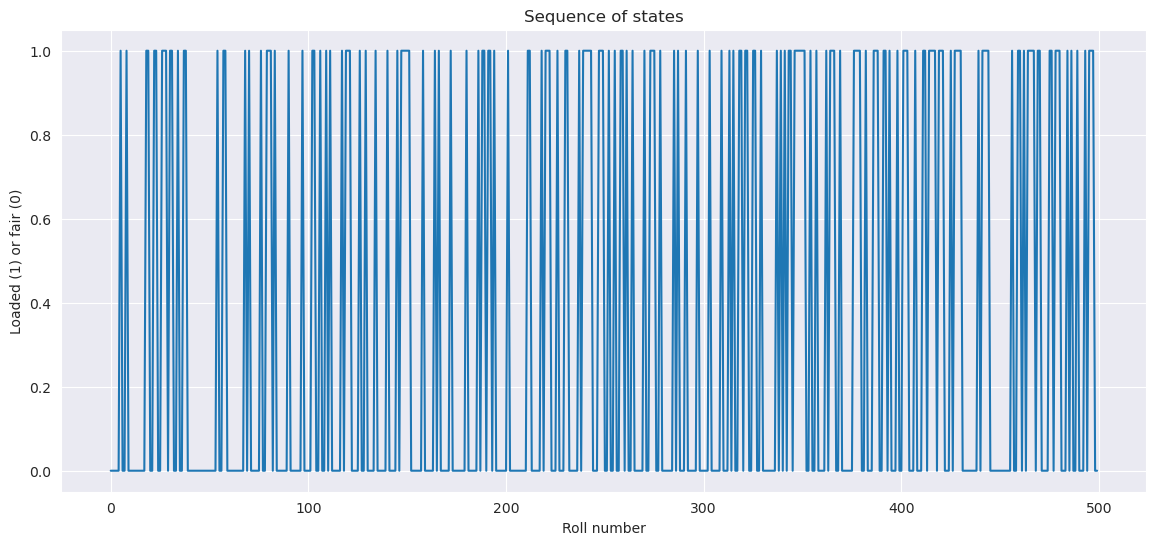

In [13]:
# Plotting sequence of states
plt.figure(figsize=(14, 6))
plt.plot(states[:500])
plt.title('Sequence of states')
plt.xlabel('Roll number')
plt.ylabel('Loaded (1) or fair (0)')
plt.show()

### Problem of HMM that this corresponds to

This problem first corresponds to evaluation since we try to evaluate the model on val set to get the best fitting model.

Then, we use the predict method to find the most likely sequence of states, which corresponds to the decoding problem.

## Part 2: Casino switching dice

We have most likely states, 1 corresponding to loaded and 0 to fair dice. 
We find how often the dice is switched from loaded to fair and vice versa.

In [14]:
print('%age chance for Casino to switch dice from loaded to fair: ', best_model.transmat_[1, 0]*100, '%')
print('%age chance for Casino to switch dice from fair to loaded: ', best_model.transmat_[0, 1]*100, '%')

%age chance for Casino to switch dice from loaded to fair:  63.63509608139617 %
%age chance for Casino to switch dice from fair to loaded:  26.495413721635913 %


This gives how often the casino switches the dice.

In [15]:
print('Casino switches from loaded to fair dice', np.sum(np.diff(states) == -1), 'times')
print('Casino switches from fair to loaded dice', np.sum(np.diff(states) == 1), 'times')

Casino switches from loaded to fair dice 9897 times
Casino switches from fair to loaded dice 9898 times


We can verify the transition rpoabbilities by taking the following ratios.

In [16]:
np.sum(np.diff(states) == -1) / np.sum(states == 1), np.sum(np.diff(states) == 1) / np.sum(states == 0)

(0.635604649669257, 0.287490197217462)

### Problem of HMM that this corresponds to

The problem in Hidden Markov Models this corresponds to is learning, since we are trying to find the transition probabilities. We also use the decoded states from the last part.

## Part 3: How is the loaded die biased?

We show the emission probability of the dice. As mentioned before, the loaded dice is biased towards 6.

In [17]:
best_model.emissionprob_[1, :]

array([5.52819788e-02, 1.13196357e-02, 2.76170858e-03, 1.25471500e-04,
       1.94099153e-09, 9.30511203e-01])

In [18]:
np.unique(rolls[states == 1], return_counts=True)

(array([5]), array([15571]))

The loaded die is biased towards 6. The rest of the numbers are equally likely. This is why the distribution of all rolls is skewed only towards 6.

In [19]:
print('Loaded die is more likely to roll 6 by a factor of', best_model.emissionprob_[1, 5]/best_model.emissionprob_[1, :5].sum())

Loaded die is more likely to roll 6 by a factor of 13.390809016275988


### Problem of HMM that this corresponds to

This corresponds to the learning problem as we are trying to find the best fitting emission probabilities.

## Task 4: Cricket

Loading data from runs.npy. This data corresponds to runs made on each ball.

In [2]:
runs = np.load('runs.npy')
print('Sequence of runs: ', runs[:100].reshape(-1), end="...")

Sequence of runs:  [1 6 4 6 6 1 4 2 1 1 2 6 0 4 3 0 4 6 1 3 2 2 2 4 0 4 0 1 4 2 0 4 1 3 6 1 4
 4 1 2 4 4 1 1 1 4 0 1 1 2 6 1 2 1 0 1 1 0 2 2 6 4 4 0 4 1 0 3 6 6 2 0 1 1
 0 0 1 2 4 0 4 4 6 0 4 4 6 2 1 2 2 2 1 6 2 1 4 4 4 1]...

Now we build an HMM model for this data. Virat Kohli being on strike corresponds to state 0, Rohit Sharma corresponds to state 1.

There is a roughly 30% chance to change states at the end of each ball.

Kohli is more liekly to score 1s and 2s, Rohit is more likely to score 4s and 6s.

Emission probability of 5 is 0.

### Finding best emission and transition probabilities

We set this initialise estimates for the parameters and fit the model.

In [9]:
hmm_model = hmm.CategoricalHMM(n_components=2, random_state=seed, init_params='s')
hmm_model.emissionprob_ = np.array([
    [0.1, 0.3, 0.3, 0.2, 0.05, 0.0, 0.05],
    [0.1, 0.05, 0.05, 0.2, 0.3, 0.0, 0.3]
])
hmm_model.transmat_ = np.array([
    [0.7, 0.3],
    [0.3, 0.7]
])

hmm_model.fit(runs.reshape(-1, 1))

CategoricalHMM(init_params='s', n_components=2, n_features=7,
               random_state=RandomState(MT19937) at 0x7F3DDEF81F40)

Now that we have fit the model. We can check the emission and transition probabilities.

In [10]:
hmm_model.emissionprob_

array([[0.14355945, 0.3446029 , 0.29794468, 0.04734541, 0.09529686,
        0.        , 0.07125071],
       [0.10965077, 0.07681112, 0.07334454, 0.04880863, 0.38958299,
        0.        , 0.30180197]])

In [11]:
hmm_model.transmat_

array([[0.60687909, 0.39312091],
       [0.33688921, 0.66311079]])

### Finding who played first and last ball

We can look at the start probability to see who likely played the first ball.

In [12]:
hmm_model.startprob_

array([9.99985239e-01, 1.47605453e-05])

We can see that Virat Kohli played the first ball, with a probability of 99.99%

To find out who played the last ball, we can look at the sequence of states and see who was on strike at the end.

In [13]:
states = hmm_model.predict(runs.reshape(-1, 1))

In [14]:
states[-1]

1

Since the last state is 1, we can say that Rohit Sharma played the last ball.